# Chuẩn bị dữ liệu

Đề tài sử dụng tập dữ liệu **Task01_BrainTumour.tar** từ [Medical Segmentation Decathlon](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2)

Mặc dù bộ dữ liệu Brain Tumor đã được chuẩn hoá trước với dạng NifTI, tuy nhiên ta cần thêm bước tiền xử lý dữ liệu với các bước

**Sub-volume** Do mỗi ảnh MRI bao hàm một lượng lớn dữ liệu, nhưng phần cứng xử lý có giới hạn dẫn đến việc tại một thời điểm ta không thể xử lý được toàn bộ dữ liệu. Ngoài ra, không phải tất cả các vùng đều cần phải được đưa vào huẩn luyện, chỉ những phần cần thiết nên việc đưa vào toàn bộ sẽ là lãng phí.

**Chuẩn hoá** do các giá trị trong ảnh MR bao gồm một phạm vi rất rộng, ta sẽ chuẩn hóa các giá trị để có giá trị trung bình bằng 0 và độ lệch chuẩn là 1.

## Hàm và thư viện hỗ trợ

In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import shutil
import glob
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

def save_optimized_case(image_data, label_data, 
                        output_image_dir, output_label_dir, 
                        output_name):
    with open(os.path.join(output_image_dir, output_name), 'wb') as f:
        np.save(f, image_data)
    with open(os.path.join(output_label_dir, output_name), 'wb') as f:
        np.save(f, label_data)
    
def load_optimized_case(image_file_path, label_file_path):
    with open(image_file_path, 'rb') as f:
        X = np.load(f)
    with open(label_file_path, 'rb') as f:
        y = np.load(f)
    return X,y

def visualize_case(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

## Sub-volume sampling

Ta xây dựng hàm `get_sub_volume` nhận vào tham số ảnh và nhãn ban đầu

- 4D image (shape: [240, 240, 155, 4])
- 3D label (shape: [240, 240, 155])

Hàm sẽ trả về

- Một vùng ngẫu nhiên có kích thước (160, 160, 16)
- Nhãn tương ứng ở dạng 1-hot (3, 160, 160, 160)

Ngoài ra, hàm này cũng áp thêm một số tiêu chí

1. Đảm bảo sau phần được lấy phải bao gồm ít nhất 5% là khối u (có thể tùy biến)
2. Số kênh (channel) được lưu ở phần tử đầu tiên của ảnh
3. Sắp xếp lại số chiều của tập nhãn
4. Giảm số chiều của nhãn bằng cách lược bỏ nhãn nền (background)

In [3]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    X = None
    y = None

    tries = 0
    
    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x + 1)
        start_y = np.random.randint(0, orig_y - output_y + 1)
        start_z = np.random.randint(0, orig_z - output_z + 1)

        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        y = to_categorical(y, num_classes=num_classes)

        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        tries += 1

        if bgrd_ratio < background_threshold:
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension order of X and y
            # (x, y, z, num_channels) to (num_channels, x, y, z)
            X = np.moveaxis(X, -1, 0)
            y = np.moveaxis(y, -1, 0)
            
            # remove background label
            y = y[1:, :, :, :]
    
            return X, y

    raise Exception(f"[ERROR] Tried {tries} times and unable to find sub-volume.")

## Thực hiện việc sub-sampling

In [5]:
DATA_IMAGE_INPUT = "./Task01_BrainTumour/imagesTr"
DATA_LABEL_INPUT = "./Task01_BrainTumour/labelsTr"

DATA_IMAGE_OUTPUT = "./Task01_BrainTumour_Optimized/imagesTr"
DATA_LABEL_OUTPUT = "./Task01_BrainTumour_Optimized/labelsTr"

# Remove old output and generate again
if os.path.isdir(DATA_IMAGE_OUTPUT):
    shutil.rmtree(DATA_IMAGE_OUTPUT)
os.mkdir(DATA_IMAGE_OUTPUT)

if os.path.isdir(DATA_LABEL_OUTPUT):
    shutil.rmtree(DATA_LABEL_OUTPUT)
os.mkdir(DATA_LABEL_OUTPUT)

# Optimize data
for image_file_path in glob.glob(os.path.join(DATA_IMAGE_INPUT, '*.nii.gz')):
    file_base_name = os.path.basename(image_file_path)
    label_file_path = os.path.join(DATA_LABEL_INPUT, file_base_name)
    
    if not os.path.isfile(label_file_path):
        raise Exception(f'[ERROR] Label file not found: {label_file_path}')
    
    print(f'-> Process file: {file_base_name}')
    image, label = load_case( \
        image_file_path, \
        label_file_path \
    )
    
    # Get sub-volume with increased size
    try:
        X, y = get_sub_volume(image, label, \
                              background_threshold=0.98, \
                              output_x = 160, output_y = 160, output_z = 16, \
                              max_tries=2000
                             )
        save_optimized_case(X, y, DATA_IMAGE_OUTPUT, DATA_LABEL_OUTPUT, file_base_name) 
    except:
        print(f'# Unable to get sub volume of {file_base_name}')
        
# Copy dataset.json
# TODO

-> Process file: BRATS_001.nii.gz
-> Process file: BRATS_002.nii.gz
-> Process file: BRATS_003.nii.gz
-> Process file: BRATS_004.nii.gz
-> Process file: BRATS_005.nii.gz
-> Process file: BRATS_006.nii.gz
-> Process file: BRATS_007.nii.gz
-> Process file: BRATS_008.nii.gz
-> Process file: BRATS_009.nii.gz
-> Process file: BRATS_010.nii.gz
-> Process file: BRATS_011.nii.gz
-> Process file: BRATS_012.nii.gz
-> Process file: BRATS_013.nii.gz
-> Process file: BRATS_014.nii.gz
-> Process file: BRATS_015.nii.gz
-> Process file: BRATS_016.nii.gz
-> Process file: BRATS_017.nii.gz
-> Process file: BRATS_018.nii.gz
-> Process file: BRATS_019.nii.gz
-> Process file: BRATS_020.nii.gz
-> Process file: BRATS_021.nii.gz
-> Process file: BRATS_022.nii.gz
-> Process file: BRATS_023.nii.gz
-> Process file: BRATS_024.nii.gz
-> Process file: BRATS_025.nii.gz
-> Process file: BRATS_026.nii.gz
-> Process file: BRATS_027.nii.gz
-> Process file: BRATS_028.nii.gz
-> Process file: BRATS_029.nii.gz
-> Process fil

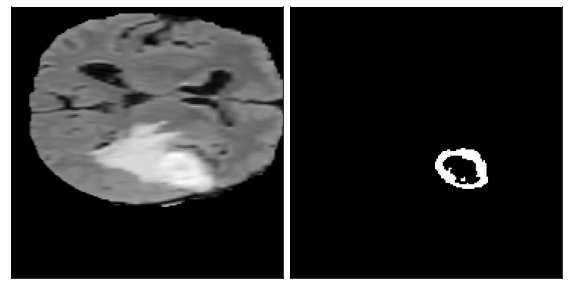

In [17]:
X, y = load_optimized_case( \
    os.path.join(DATA_IMAGE_OUTPUT, 'BRATS_001.nii.gz'), \
    os.path.join(DATA_LABEL_OUTPUT, 'BRATS_001.nii.gz') \
)

visualize_case(X[0, :, :, :], y[2])